## Operations benchmarked
The aim of this notebook is to benchmark the fundamental linear algebra operation in the two frameworks. The operations that will be compared are the followings:
1. definition of variables
1. create a vector
1. activation function
1. dot product
1. matrix multiplication
1. flatten a vector
1. normalize a vector
1. define a kernel

## Workflow - General steps
For each of them we will follow these steps:
- define 2 benchmark functions (one for each framework) that contains a reasonable amount of computation
- set the necessary random seeds (framework, python, numpy)
- run the benchmark function multiple times (e.g. 100 times)
- record the time for each run 
- plot the two runs on a diagram
- run an HP to understand if the two distributions are significantly different
- take the conclusion: which is better and why?

## Benchmark Detail: Timing Function 
To benchmark the execution time of python function we used the library function process_time() before and after the function execution.

#### time.process_time() → float
Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process. It does not include time elapsed during sleep. It is process-wide by definition. The reference point of the returned value is undefined, so that only the difference between the results of consecutive calls is valid.

*New in version 3.3.*

In [1]:
import time

start = time.process_time()
# your function here
end = time.process_time()
print("This is the general error magnitude: ", end - start)

This is the general error magnitude:  3.899999999995574e-05


### Benchmark: Other CPU and RAM usages
source: https://stackoverflow.com/questions/276052/how-to-get-current-cpu-and-ram-usage-in-python

UPDATE: Here is some example usages of psutil:

In [38]:
#!/usr/bin/env python
import psutil
# gives a single float value
psutil.cpu_percent()
# gives an object with many fields
psutil.virtual_memory()
# you can convert that object to a dictionary 
dict(psutil.virtual_memory()._asdict())

{'total': 17179869184,
 'available': 7463714816,
 'percent': 56.6,
 'used': 9713758208,
 'free': 289538048,
 'active': 7206535168,
 'inactive': 4395606016,
 'wired': 2507223040}

## Import the two frameworks

In [2]:
import mxnet as mx
import tensorflow as tf

print("Tensorflow version (by Google): ", tf.__version__)
print("MXnet version (by Amazon): ", mx.__version__)

Tensorflow version (by Google):  2.0.0
MXnet version (by Amazon):  1.5.1


In [3]:
import numpy as np

In [33]:
import pandas as pd

def plot_timing(mx_list, tf_list):
    mx_s = pd.Series(mx_list)
    tf_s = pd.Series(tf_list)

    df = pd.concat([mx_s, tf_s], axis=1)
    df = df.rename(columns = {0:"mxnet", 1:"tensorflow"})
    return df.plot()

In [35]:
# test if the two samples are significantly different
# https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
from scipy.stats import ttest_ind

def test_independence(mx_list, tf_list):
    stat, p = ttest_ind(mx_list, tf_list)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

# 1. Definition of a Variable
Task to Benchmark: Creation of a huge number of variables (e.g. 1000, 10000, etc...)

Common to both frameworks: the data type, dimensions and name of the variables

In [5]:
# MXnet
'''
The Symbol API in Apache MXNet is an interface for symbolic programming. It features the use 
of computational graphs, reduced memory usage, and pre-use function optimization.

mxnet.symbol.Variable
(name, attr=None, shape=None, lr_mult=None, wd_mult=None, dtype=None, init=None, stype=None, **kwargs)
'''
# Tensorflow
'''
A TensorFlow variable is the best way to represent shared, persistent state manipulated by your program.
Variables are manipulated via the tf.Variable class. A tf.Variable represents a tensor whose value can 
be changed by running ops on it. Specific ops allow you to read and modify the values of this tensor. 
Higher level libraries like tf.keras use tf.Variable to store model parameters. This guide covers how 
to create, update, and manage tf.Variables in TensorFlow.

tf.Variable(
    initial_value=None, <-- not a fair comparison if we initialize also the tensor
    trainable=None,
    validate_shape=True,
    caching_device=None,
    name=None,
    variable_def=None,
    dtype=None,
    import_scope=None,
    constraint=None,
    synchronization=tf.VariableSynchronization.AUTO,
    aggregation=tf.compat.v1.VariableAggregation.NONE,
    shape=None
)
Placeholders are more similar to symbols in MXnet because they do not require an initial value
dtype: The type of elements in the tensor to be fed.
shape: The shape of the tensor to be fed (optional). If the shape is not specified, 
you can feed a tensor of any shape.
name: A name for the operation (optional).
tf.compat.v1.placeholder(
    dtype,
    shape=None,
    name=None
)
'''
# Create a variable/symbol without values
name_of_variable = "weights"
w_mx = mx.symbol.Variable(name_of_variable, shape=(1024, 1024), dtype = np.float32)
print(w_mx)
'''
# disable eager execution to use placeholders
tf.compat.v1.disable_eager_execution()

w_tf = tf.compat.v1.placeholder(tf.float32, name = name_of_variable,  shape=(1024, 1024))
print(w_tf)

# reenable eager execution
tf.compat.v1.enable_eager_execution()
'''
# there is no point of comparing mxnet with older functions of tf1 that are deprecated in tf2
print("No benchmark for variable definition")

<Symbol weights>
No benchmark for variable definition


# 2. Vector Creation
Task to Benchmark: Create a huge amount of vectors with the two proprietary library functions of the two frameworks

Common to both frameworks: The vectors created (ones, zeros, specific numbers) should be given as numpy array input to both frameworks.

In [25]:
microbenchmark_seed = 42
dimensions = 1000
nr_vectors = 50

from typing import List

# set the seed
np.random.seed(microbenchmark_seed)
'''
# generate a set of vectors in numpy of the same dimensions
bag_of_vectors : List[np.ndarray] = []
for _ in range(nr_vectors):
    bag_of_vectors += [np.random.rand(1, dimensions)]
#print(bag_of_vectors)
'''

# define the two benchmarking functions
def mx_vector_creation(bag_of_vectors):
    mx_bag_of_vectors : List[mxnet.ndarray] = []
    for np_vector in bag_of_vectors:
        mx_bag_of_vectors += [mx.nd.array(np_vector, dtype='float32')]
    return mx_bag_of_vectors

def tf_vector_creation(bag_of_vectors):
    tf_bag_of_vectors : List[tf.Tensor] = []
    for np_vector in bag_of_vectors:
        tf_bag_of_vectors += [tf.convert_to_tensor(np_vector, dtype=tf.float32)]
    return tf_bag_of_vectors

In [32]:
NR_TRIES = 150

mx_timing_vector_creation = []
tf_timing_vector_creation = []

for x in range(NR_TRIES):
    print(x, end="-")
    np.random.seed(seed=x) 
    
    # generate common random stuff
    bag_of_vectors : List[np.ndarray] = []
    # ssame bag of vectors to generate
    for _ in range(nr_vectors):
        bag_of_vectors += [np.random.rand(1, dimensions)]
    
    # mxnet
    start_mx = time.process_time()
    mx_vector_creation(bag_of_vectors)
    end_mx = time.process_time()
    elapsed_mx = end_mx - start_mx
    mx_timing_vector_creation += [elapsed_mx]
    
    # tensorflow
    start_tf = time.process_time()
    tf_vector_creation(bag_of_vectors)
    end_tf = time.process_time()
    elapsed_tf = end_tf - start_tf
    tf_timing_vector_creation += [elapsed_tf]
    
    # to verify the equivalence
    #assert(np.array_equal(result_matmul, result_tensordot))

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-

stat=83.663, p=0.000
Probably different distributions


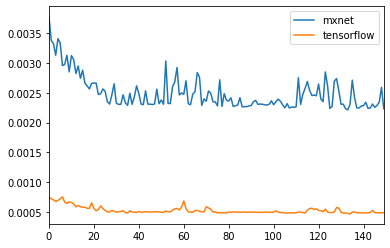

In [36]:
plot_timing(mx_timing_vector_creation, tf_timing_vector_creation)
test_independence(mx_timing_vector_creation, tf_timing_vector_creation)

Result: Tensorflow wins in converting array from numpy

Why?: it maybe because they are using an ad hoc function for conversion to tf rater than having the using the constructor as mxnet is doing. The constructor is obviously more intuitive and easy to use, but the ad hoc function has clearly better performance.

# 3. Activation Function
Task to Benchmark: Apply the activation functions to a sequence of vectors of a fixed dimensions

Common to both frameworks: the same vectors (created in numpy) are used and the activation functions present in both frameworks are used

# 4. Dot Product
Task to Benchmark: Do the dot product between a lot of vectors randomly picked from a previously created collection of vectors (same length to allow the dot product). These vectors should be reasonably long (e.g. 10k)

Common to both frameworks: The same random bag of vectors is used. This collection is created in its proprietary library function: tensor and ndarray, before benchmarking. The randomly picked vectors are the same.

# 5. Matrix Multiplication
Task to Benchmark: Multiply a bunch of matrices of different dimensions.

Common to both frameworks: The matrices are randomly generated before the benchmark takes place and they are stored in their proprietary format: tensor and ndarray. The randomness is the same in both frameworks. Random generation is handled by numpy.

# 6. Flatten vector/tensor
Task to Benchmark: Flatten a preconstructed collection (e.g. # elements = 1000)  of multidimensional array.

Common to both frameworks: The two collections are created before the benchmark by using the proprietary functions. The two collections are identical. The chosen array are the same for both frameworks.


# 7. Normalize vector/tensor
Task to Benchmark: Normalize a preconstructed collection (e.g. # elements = 1000) of multidimensional array.

Common to both frameworks: The two collections are created before the benchmark by using the proprietary functions. The two collections are identical. The chosen array are the same for both frameworks.